In [345]:
from __future__ import print_function
from packaging.version import parse as Version
from platform import python_version

OK = '\x1b[42m[ OK ]\x1b[0m'
FAIL = "\x1b[41m[FAIL]\x1b[0m"

try:
    import importlib
except ImportError:
    print(FAIL, "Python version 3.11 is required,"
                " but %s is installed." % sys.version)

def import_version(pkg, min_ver, fail_msg=""):
    mod = None
    try:
        mod = importlib.import_module(pkg)
        if pkg in {'PIL'}:
            ver = mod.VERSION
        else:
            ver = mod.__version__
        if Version(ver) == Version(min_ver):
            print(OK, "%s version %s is installed."
                  % (lib, min_ver))
        else:
            print(FAIL, "%s version %s is required, but %s installed."
                  % (lib, min_ver, ver))    
    except ImportError:
        print(FAIL, '%s not installed. %s' % (pkg, fail_msg))
    return mod


# first check the python version
pyversion = Version(python_version())

if pyversion >= Version("3.11.4"):
    print(OK, "Python version is %s" % pyversion)
elif pyversion < Version("3.11"):
    print(FAIL, "Python version 3.11 is required,"
                " but %s is installed." % pyversion)
else:
    print(FAIL, "Unknown Python version: %s" % pyversion)

    
print()
requirements = {'numpy': "1.24.4", 'matplotlib': "3.7.2",'sklearn': "1.3.0", 
                'pandas': "2.0.3",'xgboost': "1.7.6", 'shap': "0.42.1", 'seaborn': "0.12.2"}

# now the dependencies
for lib, required_version in list(requirements.items()):
    import_version(lib, required_version)

[ OK ] Python version is 3.11.4

[ OK ] numpy version 1.24.4 is installed.
[ OK ] matplotlib version 3.7.2 is installed.
[ OK ] sklearn version 1.3.0 is installed.
[ OK ] pandas version 2.0.3 is installed.
[ OK ] xgboost version 1.7.6 is installed.
[ OK ] shap version 0.42.1 is installed.
[ OK ] seaborn version 0.12.2 is installed.


In [346]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split,StratifiedKFold, GridSearchCV, ParameterGrid
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import fbeta_score, make_scorer,confusion_matrix,ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt
import xgboost

In [347]:
import pandas as pd
df = pd.read_csv('data/heart_disease_health_indicators_BRFSS2015.csv')
X = df.loc[:,df.columns!='HeartDiseaseorAttack']
y = df['HeartDiseaseorAttack']

In [348]:
ordinal_ftrs = ['Diabetes','Education','Income','GenHlth','MentHlth','PhysHlth','Age']
ordinal_cats = [[0,1,2],[1,2,3,4,5,6],[1,2,3,4,5,6,7,8],[1,2,3,4,5],\
                [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30],\
                [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30],\
                [0,1,2,3,4,5,6,7,8,9,10,11,12,13]]
onehot_ftrs = ['HighBP','HighChol','CholCheck','Smoker','Stroke','PhysActivity','Fruits',\
               'Veggies','HvyAlcoholConsump','AnyHealthcare','NoDocbcCost','DiffWalk','Sex']
std_ftrs = ['BMI']

preprocessor = ColumnTransformer(
    transformers=[
        ('ord', OrdinalEncoder(categories = ordinal_cats), ordinal_ftrs),
        ('onehot', OneHotEncoder(handle_unknown='ignore'), onehot_ftrs),
        ('std', StandardScaler(), std_ftrs)])

In [349]:
random_state = 7
X_other, X_test, y_other, y_test = train_test_split(X,y,test_size = 0.02,stratify=y,random_state=random_state)
X_mid,X_small,y_mid,y_small = train_test_split(X_other,y_other,test_size=0.01,
                                                           stratify=y_other,random_state=random_state)
X_mid_rest, X_small_val, y_mid_rest,y_small_val = train_test_split(X_mid,y_mid,test_size=0.0075,
                                                                    stratify=y_mid,random_state=random_state)
print(X_small.shape)
print(X_small_val.shape)
neg = len(y[y==0])
pos = len(y[y==1])

rec = 1
pre = pos/(pos+neg)

# print((1+(1.5**2))*pre/(1.5**2*pre+1))
# print(fbeta_score(y,np.ones(y.shape),beta=1.5))
print(neg)
print(pos)
print(neg/pos)
print(fbeta_score(y,np.ones(y.shape),beta=2))
base_f2 = fbeta_score(y,np.ones(y.shape),beta=2)

(2487, 21)
(1846, 21)
229787
23893
9.617335621311682
0.3420596016629826


In [350]:
f2_scorer = make_scorer(fbeta_score, beta=2)

In [351]:
def MLpipe_StratKFold_fbeta2(X, y, preprocessor, ML_algo, param_grid):  
    train_scores = []
    val_scores = []
    best_models = []

    for random_state in range(10):
        X_train,X_val,y_train,y_val = train_test_split(X,y,train_size=0.95,stratify=y,random_state=random_state)
        skf=StratifiedKFold(n_splits=4,shuffle=True,random_state=random_state)

        pipe = make_pipeline(preprocessor,StandardScaler(),ML_algo)

        grid = GridSearchCV(pipe,param_grid=param_grid,scoring=f2_scorer,cv=skf,
                            return_train_score=True,n_jobs=7,verbose=2)
        grid.fit(X_train,y_train)
        best_models.append(grid)
    
        y_train_pred = grid.predict(X_train)
        y_val_pred = grid.predict(X_val)
        
        train_scores.append(fbeta_score(y_train,y_train_pred,beta=2))
        val_scores.append(fbeta_score(y_val,y_val_pred,beta=2))
  
    return train_scores, val_scores, best_models

In [352]:
lr_l1_clf = LogisticRegression(penalty='l1',solver='saga',
                         random_state=random_state)
param_grid = {'logisticregression__C':np.logspace(-2,2,5),
             'logisticregression__class_weight':[None,'balanced']}

lr_l1_train_scores, lr_l1_val_scores, lr_l1_best_models = MLpipe_StratKFold_fbeta2(X_other,y_other,preprocessor,
                                                                           lr_l1_clf,param_grid)

print('mean max f-beta 2 train:',np.mean(lr_l1_train_scores))
print('std max f-beta 2 train:',np.std(lr_l1_train_scores))
print(lr_l1_train_scores)
print('mean max f-beta 2 val:',np.mean(lr_l1_val_scores))
print('std max f-beta 2 val:',np.std(lr_l1_val_scores))
print(lr_l1_val_scores)

plt.plot(range(10),lr_l1_train_scores,label='train')
plt.plot(range(10),lr_l1_val_scores,label='val')
plt.legend()
plt.show()

Fitting 4 folds for each of 10 candidates, totalling 40 fits


103787.51s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
103787.53s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
103787.54s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
103787.57s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
103787.57s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
103787.60s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
103787.65s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
0.01s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.01s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - Note: Debugging will proceed.

[CV] END logisticregression__C=0.01, logisticregression__class_weight=None; total time=   3.7s
[CV] END logisticregression__C=0.01, logisticregression__class_weight=None; total time=   3.8s
[CV] END logisticregression__C=0.01, logisticregression__class_weight=None; total time=   3.9s
[CV] END logisticregression__C=0.01, logisticregression__class_weight=None; total time=   4.1s
[CV] END logisticregression__C=0.01, logisticregression__class_weight=balanced; total time=   4.9s
[CV] END logisticregression__C=0.01, logisticregression__class_weight=balanced; total time=   5.0s
[CV] END logisticregression__C=0.01, logisticregression__class_weight=balanced; total time=   5.1s
[CV] END logisticregression__C=0.1, logisticregression__class_weight=None; total time=   3.7s
[CV] END logisticregression__C=0.1, logisticregression__class_weight=None; total time=   3.5s
[CV] END logisticregression__C=0.1, logisticregression__class_weight=None; total time=   3.4s
[CV] END logisticregression__C=0.01, logi

KeyboardInterrupt: 

In [ ]:
import pickle
file = open('results/lr_l1_grid.save', 'wb')
pickle.dump((lr_l1_train_scores, lr_l1_val_scores, lr_l1_best_models),file)
file.close()

Fitting 4 folds for each of 10 candidates, totalling 40 fits
[CV] END logisticregression__C=0.01, logisticregression__class_weight=None; total time=   2.9s
[CV] END logisticregression__C=0.01, logisticregression__class_weight=None; total time=   3.1s
[CV] END logisticregression__C=0.01, logisticregression__class_weight=balanced; total time=   3.0s
[CV] END logisticregression__C=0.01, logisticregression__class_weight=None; total time=   3.1s
[CV] END logisticregression__C=0.01, logisticregression__class_weight=balanced; total time=   3.3s
[CV] END logisticregression__C=0.01, logisticregression__class_weight=None; total time=   3.0s
[CV] END logisticregression__C=0.01, logisticregression__class_weight=balanced; total time=   3.0s
[CV] END logisticregression__C=0.01, logisticregression__class_weight=balanced; total time=   3.4s
[CV] END logisticregression__C=0.1, logisticregression__class_weight=None; total time=   2.9s
[CV] END logisticregression__C=0.1, logisticregression__class_weight=

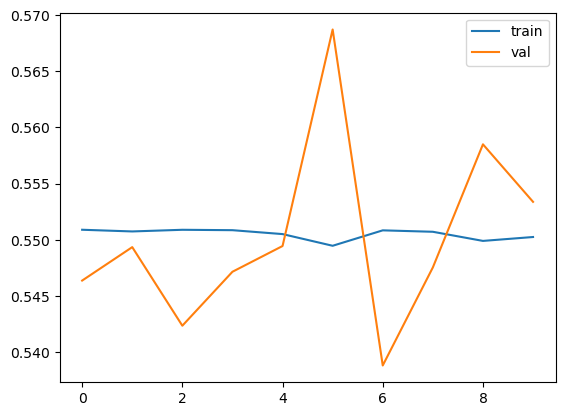

In [ ]:
lr_clf = LogisticRegression(penalty='l2',solver='lbfgs',
                         random_state=random_state)
param_grid = {'logisticregression__C':np.logspace(-2,2,5),
             'logisticregression__class_weight':[None,'balanced']}

lr_train_scores, lr_val_scores, lr_best_models = MLpipe_StratKFold_fbeta2(X_other,y_other,preprocessor,
                                                                           lr_clf,param_grid)

print('mean max f-beta 2 train:',np.mean(lr_train_scores))
print('std max f-beta 2 train:',np.std(lr_train_scores))
print(lr_train_scores)
print('mean max f-beta 2 val:',np.mean(lr_val_scores))
print('std max f-beta 2 val:',np.std(lr_val_scores))
print(lr_val_scores)

plt.plot(range(10),lr_train_scores,label='train')
plt.plot(range(10),lr_val_scores,label='val')
plt.legend()
plt.show()

In [ ]:
import pickle
file = open('results/lr_grid.save', 'wb')
pickle.dump((lr_train_scores, lr_val_scores, lr_best_models),file)
file.close()

In [ ]:
import pickle
file = open('results/lr_l1_grid.save', 'rb')
lr_l1_train_scores, lr_l1_val_scores, lr_l1_best_models = pickle.load(file)
file.close()

file = open('results/lr_grid.save', 'rb')
lr_train_scores, lr_val_scores, lr_best_models = pickle.load(file)
file.close()

file = open('results/rfc_grid.save', 'rb')
rfc_train_scores, rfc_val_scores, rfc_best_models = pickle.load(file)
file.close()

file = open('results/xgb_edited_grid.save', 'rb')
xgb_train_scores, xgb_val_scores, xgb_best_models, \
    xgb_best_preprocessors, xgb_best_final_scalers = pickle.load(file)
file.close()

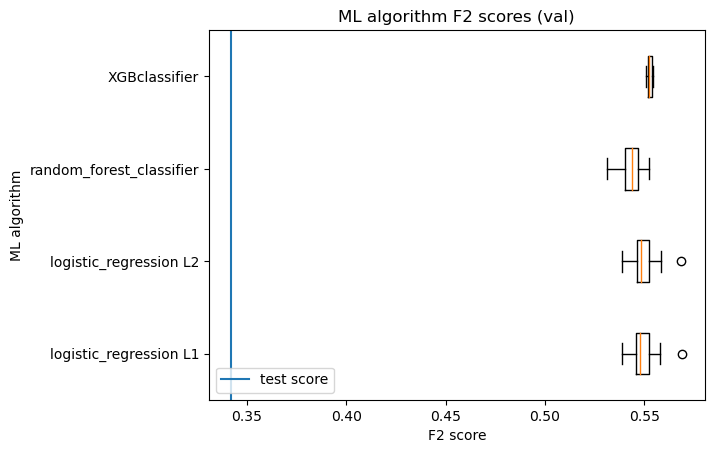

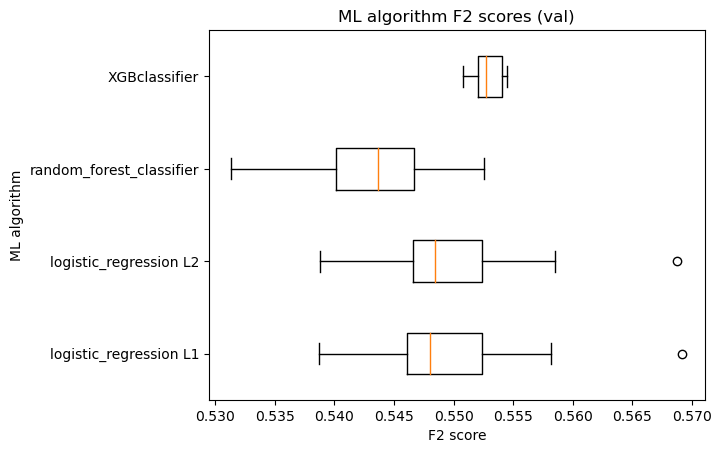

In [ ]:
val_scores = [lr_l1_val_scores, lr_val_scores, rfc_val_scores, xgb_val_scores]

plt.boxplot(val_scores, vert=False)
plt.xlabel('F2 score')
plt.ylabel('ML algorithm')
plt.yticks([1,2,3,4],['logistic_regression L1','logistic_regression L2',
             'random_forest_classifier','XGBclassifier'])
plt.axvline(base_f2,label='test score')
plt.title('ML algorithm F2 scores (val)')
plt.legend(loc='lower left')
plt.savefig('f2 scores (val).png', dpi=300,bbox_inches='tight')
plt.show()

plt.boxplot(val_scores, vert=False)
plt.xlabel('F2 score')
plt.ylabel('ML algorithm')
plt.yticks([1,2,3,4],['logistic_regression L1','logistic_regression L2',
             'random_forest_classifier','XGBclassifier'])
plt.title('ML algorithm F2 scores (val)')
plt.savefig('f2 scores (val) no base.png', dpi=300,bbox_inches='tight')
plt.show()

In [ ]:
def get_test_scores(X_test, y_test, models):
    test_scores = []
    for model in models:
         test_scores.append(fbeta_score(y_test, model.predict(X_test),beta=2))
    return test_scores

In [ ]:
def get_xgb_test_scores(X_test, y_test, model, preprocessor, scaler):
    test_scores = []
    for i in range(10):
         X_test_prep = scaler[i].transform(preprocessor[i].transform(X_test))
         test_scores.append(fbeta_score(y_test, model[i].predict(X_test_prep),beta=2))
    return test_scores

In [427]:
lr_l1_test_scores = get_test_scores(X_test,y_test,lr_l1_best_models)
lr_test_scores = get_test_scores(X_test,y_test,lr_best_models)
rfc_test_scores = get_test_scores(X_test,y_test,rfc_best_models)
xgb_test_scores = get_xgb_test_scores(X_test,y_test,xgb_best_models,xgb_best_preprocessors,xgb_best_final_scalers)

ValueError: Feature shape mismatch, expected: 33, got 34

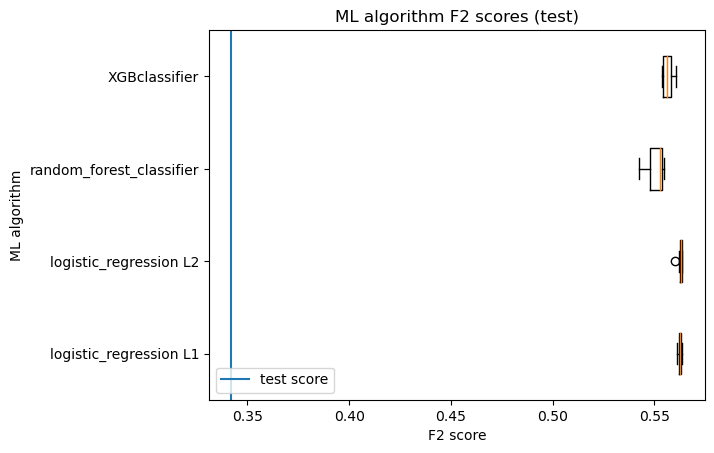

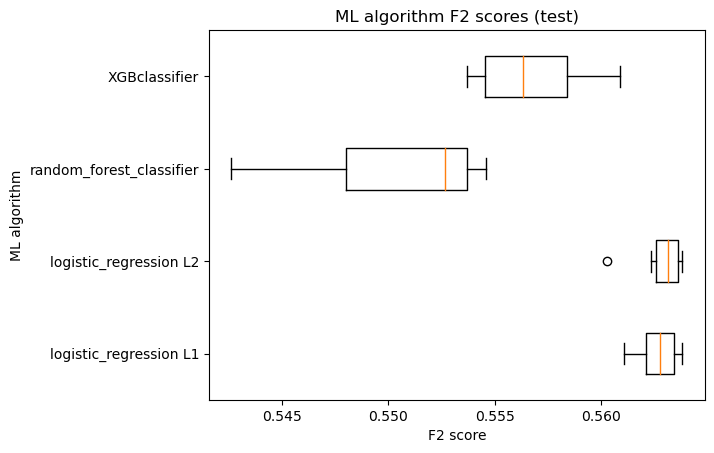

In [428]:
test_scores = [lr_l1_test_scores, lr_test_scores, rfc_test_scores, xgb_test_scores]

plt.boxplot(test_scores, vert=False)
plt.xlabel('F2 score')
plt.ylabel('ML algorithm')
plt.yticks([1,2,3,4],['logistic_regression L1','logistic_regression L2',
             'random_forest_classifier','XGBclassifier'])
plt.axvline(base_f2,label='test score')
plt.title('ML algorithm F2 scores (test)')
plt.legend(loc='lower left')
plt.savefig('f2 scores (test).png', dpi=300,bbox_inches='tight')
plt.show()

plt.boxplot(test_scores, vert=False)
plt.xlabel('F2 score')
plt.ylabel('ML algorithm')
plt.yticks([1,2,3,4],['logistic_regression L1','logistic_regression L2',
             'random_forest_classifier','XGBclassifier'])
plt.title('ML algorithm F2 scores (test)')
plt.savefig('f2 scores (test) no base.png', dpi=300,bbox_inches='tight')
plt.show()

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rfc_clf = RandomForestClassifier(n_estimators=10,random_state=random_state,verbose=True)
param_grid = {'randomforestclassifier__max_depth': [None,1,10,100],
              'randomforestclassifier__max_features': [None,0.33,0.66,1.0],
              'randomforestclassifier__class_weight': [None,'balanced','balanced_subsample']}

rfc_train_scores, rfc_val_scores, rfc_best_models = MLpipe_StratKFold_fbeta2(X_other,y_other,preprocessor,
                                                                              rfc_clf,param_grid)

print('mean max f-beta 2 train:',np.mean(rfc_train_scores))
print('std max f-beta 2 train:',np.std(rfc_train_scores))
print(rfc_train_scores)
print('mean max f-beta 2 val:',np.mean(rfc_val_scores))
print('std max f-beta 2 val:',np.std(rfc_val_scores))
print(rfc_val_scores)

plt.plot(range(10),rfc_train_scores,label='train')
plt.plot(range(10),rfc_val_scores,label='val')
plt.legend()
plt.show()

Fitting 4 folds for each of 48 candidates, totalling 192 fits
[CV] END randomforestclassifier__class_weight=None, randomforestclassifier__max_depth=None, randomforestclassifier__max_features=0.33; total time=   5.5s
[CV] END randomforestclassifier__class_weight=None, randomforestclassifier__max_depth=None, randomforestclassifier__max_features=0.33; total time=   5.6s
[CV] END randomforestclassifier__class_weight=None, randomforestclassifier__max_depth=None, randomforestclassifier__max_features=0.33; total time=   5.6s
[CV] END randomforestclassifier__class_weight=None, randomforestclassifier__max_depth=None, randomforestclassifier__max_features=0.33; total time=   4.7s
[CV] END randomforestclassifier__class_weight=None, randomforestclassifier__max_depth=None, randomforestclassifier__max_features=None; total time=  11.9s
[CV] END randomforestclassifier__class_weight=None, randomforestclassifier__max_depth=None, randomforestclassifier__max_features=None; total time=  12.0s
[CV] END rando

KeyboardInterrupt: 

In [ ]:
import pickle
file = open('results/rfc_grid.save', 'wb')
pickle.dump((rfc_train_scores, rfc_val_scores, rfc_best_models),file)
file.close()

In [ ]:
from sklearn.svm import SVC


svc_clf = SVC(verbose=True)
param_grid = {
    'svc__gamma': np.logspace(-1,1,3),
    'svc__C': np.logspace(-1,1,3),
    'svc__class_weight':[None,'balanced']
}
#SWITCH SMALL TO OTHER
svc_train_scores, svc_val_scores, svc_best_models = MLpipe_StratKFold_fbeta2(X_small,y_small,preprocessor,
                                                                             svc_clf,param_grid)

print('mean max f-beta 2 train:',np.mean(svc_train_scores))
print('std max f-beta 2 train:',np.std(svc_train_scores))
print(svc_train_scores)
print('mean max f-beta 2 val:',np.mean(svc_val_scores))
print('std max f-beta 2 val:',np.std(svc_val_scores))
print(svc_val_scores)

plt.plot(range(10),svc_train_scores,label='train')
plt.plot(range(10),svc_val_scores,label='val')
plt.legend()
plt.show()

Fitting 4 folds for each of 18 candidates, totalling 72 fits
[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]................................


..
.......*.*..*..*.......................................*.**
optimization finished, #iter = 11918
.obj = -411.108431, rho = -0.978392
nSV = 7931, nBSV = 2769
Total nSV = 7931
*.*.*.*....................*
optimization finished, #iter = 11800
obj = -410.927703, rho = -0.977840
nSV = 7915, nBSV = 2785
Total nSV = 7915
.*
optimization finished, #iter = 12268
obj = -411.014121, rho = -0.978201
nSV = 7941, nBSV = 2788
Total nSV = 7941
.*
optimization finished, #iter = 12198
obj = -411.097027, rho = -0.977415
nSV = 7992, nBSV = 2758
Total nSV = 7992
*
optimization finished, #iter = 21108
obj = -406.684912, rho = -0.985563
nSV = 16537, nBSV = 2182
Total nSV = 16537
*.*.*
optimization finished, #iter = 21324
obj = -406.611369, rho = -0.985679
nSV = 16653, nBSV = 2202
Total nSV = 16653
*
optimization finished, #iter = 21146
obj = -406.507848, r

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


.[LibSVM]...........[CV] END svc__C=0.1, svc__class_weight=None, svc__gamma=10.0; total time= 2.0min
[LibSVM]...........[CV] END svc__C=0.1, svc__class_weight=None, svc__gamma=10.0; total time= 2.0min
[LibSVM]...
...*.*.*
optimization finished, #iter = 15814
obj = -1204.799412, rho = 0.426600
nSV = 14604, nBSV = 12909
Total nSV = 14604
...[CV] END svc__C=0.1, svc__class_weight=None, svc__gamma=10.0; total time= 2.1min
[LibSVM]............................[CV] END svc__C=0.1, svc__class_weight=balanced, svc__gamma=0.1; total time=  50.2s
[LibSVM]...........*.*
optimization finished, #iter = 21521
obj = -1705.373107, rho = 0.470786
nSV = 21003, nBSV = 18962
Total nSV = 21003
..................
*.*.*
optimization finished, #iter = 21168
obj = -1708.340304, rho = 0.451846
nSV = 21030, nBSV = 18947
Total nSV = 21030
........
.*.*.*
optimization finished, #iter = 21084
obj = -1704.610108, rho = 0.457965
nSV = 20987, nBSV = 18937
Total nSV = 20987
...[CV] END svc__C=0.1, svc__class_weight=None

In [ ]:
# def MLpipe_XGB_fbeta2(X, y, preprocessor, param_grid):

#     train_scores = []
#     val_scores = []
#     best_models = []

#     # your code here...
#     for random_state in range(10):
#         X_other,X_eval,y_other,y_eval = train_test_split(X,y,train_size=0.9,stratify=y,random_state=random_state)
#         X_train,X_val,y_train,y_val = train_test_split(X_other,y_other,train_size=0.9,stratify=y_other,random_state=random_state)
        
#         clf = xgboost.XGBClassifier(early_stopping_rounds=50, learning_rate=0.03, missing=np.nan, 
#                                     seed=random_state, colsample_bytree=0.9, subsample=0.66,
#                                     eval_metric=f2_scorer,num_trees=100000)
        
#         skf=StratifiedKFold(n_splits=4,shuffle=True,random_state=random_state)

#         pipe = make_pipeline(preprocessor,StandardScaler(),clf)
#         # X_train_prep = preprocessor.fit_transform(X_train)
#         # # X_val_prep = preprocessor.transform(X_val)
#         # X_eval_prep = preprocessor.transform(X_eval)

#         # final_scaler = StandardScaler()
#         # X_train_prep = final_scaler.fit_transform(X_train)
#         # # X_val_prep = final_scaler.transform(X_val)
#         # X_eval_prep = final_scaler.transform(X_eval)


#         # 'estimator__columntransformer', 'estimator__standardscaler'
#         grid = GridSearchCV(pipe,param_grid=param_grid,scoring=f2_scorer,
#                             cv=skf,return_train_score=True,n_jobs=7,verbose=2)
        
#         X_eval_col = grid.get_params()['estimator__columntransformer'].transform(X_eval)
#         X_eval_prep = grid.get_params()['estimator__standardscaler'].transform(X_eval_col)
#         # print(grid.get_params().keys())
#         grid.fit(X_train,y_train,eval_set=[(X_eval_prep,y_eval)])
#         y_train_pred = grid.predict(X_train)
#         y_val_pred = grid.predict(X_val)
        
#         train_scores.append(fbeta_score(y_train,y_train_pred,beta=2))
#         val_scores.append(fbeta_score(y_val,y_val_pred,beta=2))
#         best_models.append(grid)

#     return train_scores, val_scores, best_models,[],[]

In [ ]:
# def xgb_f2(predt: np.ndarray, dtrain: xgb.DMatrix) -> Tuple[str, float]:
#   '''returns classification f1_score using 0.5 threshold.
#      proba_y: 1x2 shape or binary classification probabilities
#      dataset: xgboost DMatrix
#   '''
#   y = dtrain.get_label()
#   tresh_func = np.vectorize(lambda x: 1 if x> 0.5 else 0)
#   pred_y = tresh_func(proba_y)
#   return 'clf_f2', fbeta_score(y, pred_y,beta=2)

In [ ]:
# def MLpipe_XGB_fbeta2(X, y, preprocessor, param_grid):

#     train_scores = []
#     val_scores = []
#     # val_split_scores = []
#     best_models = []
#     best_preprocessors = []
#     best_final_scalers = []

#     mean_train_scores = []
#     mean_val_scores = []

#     nr_states = 10

#     # your code here...
#     for random_state in range(nr_states):
#         X_other,X_eval,y_other,y_eval = train_test_split(X,y,train_size=0.999,stratify=y,random_state=random_state)
#         #X_train,X_val,y_train,y_val = train_test_split(X_other,y_other,train_size=0.9,stratify=y_other,random_state=random_state)
#         print(X_eval.shape)
#         skf=StratifiedKFold(n_splits=4,shuffle=True,random_state=random_state)

#         split_train_scores = []
#         split_val_scores = []
#         split_models = []

#         split_preprocessors = []
#         split_final_scalers = []

#         # mean_train_scores = []
#         # mean_val_scores = []


#         for train_index, val_index in skf.split(X_other,y_other):
#             X_train_skf = X_other.iloc[train_index]
#             y_train_skf = y_other.iloc[train_index]
#             X_val_skf = X_other.iloc[val_index]
#             y_val_skf = y_other.iloc[val_index]

#             X_train_skf_col = preprocessor.fit_transform(X_train_skf)
#             X_val_skf_col = preprocessor.transform(X_val_skf)
#             X_eval_col = preprocessor.transform(X_eval)

#             final_scaler = StandardScaler()
#             X_train_skf_prep = final_scaler.fit_transform(X_train_skf_col)
#             X_val_skf_prep = final_scaler.transform(X_val_skf_col)
#             X_eval_prep = final_scaler.transform(X_eval_col)
        
#             train_score = np.zeros(len(ParameterGrid(param_grid)))
#             val_score = np.zeros(len(ParameterGrid(param_grid)))
#             models = []

#             # split_preprocessors.append(preprocessor)
#             # split_final_scalers.append(final_scaler)
            
#             # loop through all combinations of hyperparameter combos
#             for p in range(len(ParameterGrid(param_grid))):
#                 params = ParameterGrid(param_grid)[p] 
#                 clf = xgboost.XGBClassifier(**params,early_stopping_rounds=100, learning_rate=0.03, missing=np.nan, 
#                                     seed=random_state, colsample_bytree=0.9, subsample=0.66, verbose=True) # initialize the classifier
                
#                 clf.fit(X_train_skf_prep,y_train_skf,eval_set=[(X_eval_prep,y_eval)],
#                         verbose=False) # fit the model
                
#                 models.append(clf) # save it
#                 # calculate train and validation accuracy scores for individual folds and hyperparameters
#                 y_train_pred = clf.predict(X_train_skf_prep)
#                 train_score[p] = fbeta_score(y_train_skf,y_train_pred,beta=2)
#                 y_val_pred = clf.predict(X_val_skf_prep)
#                 val_score[p] = fbeta_score(y_val_skf,y_val_pred,beta=2)
            
#             #need to save all hyperparameter and fold combinations to average the folds values for
#             #each hyperparameter, then find the best hyperparameter val score average from that
#             #then thay hyperparameter combo is best

#             split_models.append(models)
#             split_train_scores.append(train_score)
#             split_val_scores.append(val_score)
#             split_preprocessors.append(preprocessor)
#             split_final_scalers.append(final_scaler)
            
#         print(split_val_scores)
#         print(len(split_val_scores[0]))

#         print(np.mean(split_train_scores, axis=0)[0])
#         print(np.mean((split_train_scores[0])))
#         print(np.mean([split_train_scores[0][0],split_train_scores[1][0],
#                       split_train_scores[2][0],split_train_scores[3][0]]))
#         print(len(np.mean(split_train_scores, axis=0)))
        
#         mean_train_scores = np.mean(split_train_scores, axis=0)
#         print("split_preprocessors shape",len(split_preprocessors))
#         print("split_final_scalers shape",len(split_final_scalers))
#         print("split_val_scores shape",len(split_val_scores))
#         # print("split_val_scores[0] shape",len(split_preprocessors[0]))

#         mean_val_scores = np.mean(split_val_scores, axis=0)
#         best_models.append(models[np.argmax(mean_val_scores[-1])])
#         print(mean_val_scores.T)
#         mean_val_scores_t = mean_val_scores.T

#         for i in range(nr_states):
#             best_preprocessors.append(split_preprocessors[np.argmax(mean_val_scores_t,axis=0)[i]])
#             best_final_scalers.append(split_final_scalers[np.argmax(mean_val_scores_t,axis=0)[i]])

    
#             # print out model parameters that maximize validation accuracy
#             # print('best model parameters:',ParameterGrid(param_grid)[np.argmax(val_score)])
#             # print('corresponding validation score:',np.max(val_score))
#             # collect and save the best model
#             # split_models.append(models[np.argmax(val_score)])
#             # split_train_scores.append(np.max(train_score))
#             # split_val_scores.append(np.max(val_score))

#             # split_train_scores.append(train_score[np.argmax(val_score)])
#             # split_val_scores.append(np.max(val_score))
#             # split_preprocessors.append(preprocessor)
#             # split_final_scalers.append(final_scaler)

#             # calculate and save the test score
#             # y_test_pred = best_models[-1].predict(X_test_prep)
#             # test_scores[i] = fbeta_score(y_test,y_test_pred,beta=2)
        
#         # best_models.append(split_models[np.argmax(split_val_scores)])
#         # best_preprocessors.append(split_preprocessors[np.argmax(split_val_scores)])
#         # best_final_scalers.append(split_final_scalers[np.argmax(split_val_scores)])
#         # train_scores.append(split_train_scores[np.argmax(split_val_scores)])

#         # print(len(val_scores))
#         # val_scores.append(fbeta_score(best_models[-1].predict(best_final_scalers[-1].transform(
#         #                                                             best_preprocessors[-1].transform(
#         #                                                                 X_val))),
#         #                                                                 y_val,
#         #                                                                 beta=2))
#         # val_scores.append(np.max(split_val_scores))

#     ###CAN"T CHOSE PROCESSORS AND STANDARD SCALERS WITH THIS :()

#     return mean_train_scores, mean_val_scores, best_models, best_preprocessors, best_final_scalers

In [ ]:
# a0 = [0,0,0]
# a1 = [1,1,1]
# a2 = [2,2,2]
# a3 = [3,3,3]

# here_array = []
# here_array.append(a0)
# here_array.append(a1)
# here_array.append(a2)
# here_array.append(a3)
# # print(len(here_array))
# # print(np.mean(here_array,axis=0))
# # print(np.mean(here_array,axis=1))
# print(np.argmax(here_array,axis=0))

[3 3 3]


In [368]:
# def MLpipe_XGB_fbeta2(X, y, preprocessor, param_grid):

#     train_scores = []
    
#     val_scores = []
#     best_models = []

#     # your code here...
#     for random_state in range(10):
#         X_other,X_eval,y_other,y_eval = train_test_split(X,y,train_size=0.9,stratify=y,random_state=random_state)
#         X_train,X_val,y_train,y_val = train_test_split(X_other,y_other,train_size=0.9,stratify=y_other,random_state=random_state)
        
#         clf = xgboost.XGBClassifier(learning_rate=0.03, missing=np.nan, 
#                                     seed=random_state, colsample_bytree=0.9, subsample=0.66)
        
#         skf=StratifiedKFold(n_splits=4,shuffle=True,random_state=random_state)

#         pipe = make_pipeline(preprocessor,StandardScaler(),clf)
# #fit the EVAL_SET TOOOOOO!!
#         grid = GridSearchCV(pipe,param_grid=param_grid,
#                             cv=skf,return_train_score=True,n_jobs=7,
#                             verbose=2)
#         grid.fit(X_train,y_train)
        
#         y_train_pred = grid.predict(X_train)
#         y_val_pred = grid.predict(X_val)
        
#         train_scores.append(fbeta_score(y_train,y_train_pred,beta=2))
#         val_scores.append(fbeta_score(y_val,y_val_pred,beta=2))
#         best_models.append(grid)

#     return train_scores, val_scores, best_models

Fitting 4 folds for each of 18 candidates, totalling 72 fits
[CV] END xgbclassifier__reg_alpha=0.1, xgbclassifier__reg_lambda=0.1, xgbclassifier__scale_pos_weight=1; total time=   0.4s
[CV] END xgbclassifier__reg_alpha=0.1, xgbclassifier__reg_lambda=0.1, xgbclassifier__scale_pos_weight=1; total time=   0.4s
[CV] END xgbclassifier__reg_alpha=0.1, xgbclassifier__reg_lambda=0.1, xgbclassifier__scale_pos_weight=1; total time=   0.4s
[CV] END xgbclassifier__reg_alpha=0.1, xgbclassifier__reg_lambda=0.1, xgbclassifier__scale_pos_weight=10; total time=   0.4s
[CV] END xgbclassifier__reg_alpha=0.1, xgbclassifier__reg_lambda=0.1, xgbclassifier__scale_pos_weight=1; total time=   0.4s
[CV] END xgbclassifier__reg_alpha=0.1, xgbclassifier__reg_lambda=0.1, xgbclassifier__scale_pos_weight=10; total time=   0.4s
[CV] END xgbclassifier__reg_alpha=0.1, xgbclassifier__reg_lambda=0.1, xgbclassifier__scale_pos_weight=10; total time=   0.5s
[CV] END xgbclassifier__reg_alpha=0.1, xgbclassifier__reg_lambda=1.0

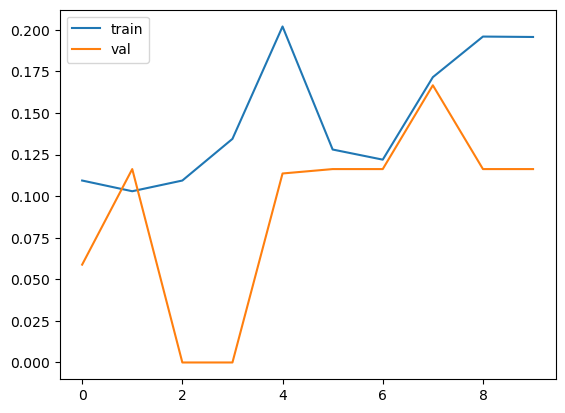

In [369]:
# # xgb_clf = xgboost.XGBClassifier(learning_rate=0.03, missing=np.nan, 
# #                                     seed=random_state, colsample_bytree=0.8, subsample=0.66)

# param_grid = {"xgbclassifier__reg_alpha": np.logspace(-1,1,3),
#               "xgbclassifier__reg_lambda": np.logspace(-1,1,3),
#               #"max_depth": [1,10,100],
#               "xgbclassifier__scale_pos_weight":[1,10]}

# #NEED TO HAVE EVAL_SET TO DO LEARNING_RATE
# # xgb_edited_train_scores, \
# # xgb_edited_val_scores, xgb_edited_best_models, \
# # xgb_best_preprocessors, xgb_best_final_scalers = MLpipe_XGB_fbeta2(X_small,
# #                                                                     y_small,
# #                                                                     preprocessor,
# #                                                                     param_grid)

# xgb_train_scores, xgb_val_scores, xgb_best_models = MLpipe_XGB_fbeta2(X_small,
#                                                                     y_small,
#                                                                     preprocessor,
#                                                                     param_grid)

# # MLpipe__fbeta2(X_other,y_other,preprocessor,param_grid)

# print('mean f-beta 2 train:',np.mean(xgb_train_scores))
# print('std f-beta 2 train:',np.std(xgb_train_scores))
# print(xgb_train_scores)
# print('mean f-beta 2 val:',np.mean(xgb_val_scores))
# print('std f-beta 2 val:',np.std(xgb_val_scores))
# print(xgb_val_scores)

# plt.plot(range(10),xgb_train_scores,label='train')
# plt.plot(range(10),xgb_val_scores,label='val')
# plt.legend()
# plt.show()

# # do not tune the number of trees, set it to a very large value like 10000
# # use early stopping instead! it will automatically determine the best number of trees based on a validation set.
# # there are a large number of hyperparameters in XGB
# # tune maybe max_depth, reg_alpha, and reg_lambda
# # the default values of some hyperparameters are not optimal
# # set colsample_bytree and subsample to values a bit smaller than 1 to avoid overfitting

Fitting 4 folds for each of 75 candidates, totalling 300 fits


121487.87s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
121487.87s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
121487.90s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
121487.91s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
121487.92s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
121487.93s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
121487.94s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
0.01s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
0.00s - Debugge

[CV] END xgbclassifier__reg_alpha=0.01, xgbclassifier__reg_lambda=0.01, xgbclassifier__scale_pos_weight=10; total time=   0.4s
[CV] END xgbclassifier__reg_alpha=0.01, xgbclassifier__reg_lambda=0.01, xgbclassifier__scale_pos_weight=1; total time=   0.4s
[CV] END xgbclassifier__reg_alpha=0.01, xgbclassifier__reg_lambda=0.01, xgbclassifier__scale_pos_weight=10; total time=   0.4s
[CV] END xgbclassifier__reg_alpha=0.01, xgbclassifier__reg_lambda=0.01, xgbclassifier__scale_pos_weight=10; total time=   0.4s
[CV] END xgbclassifier__reg_alpha=0.01, xgbclassifier__reg_lambda=0.01, xgbclassifier__scale_pos_weight=1; total time=   0.4s
[CV] END xgbclassifier__reg_alpha=0.01, xgbclassifier__reg_lambda=0.01, xgbclassifier__scale_pos_weight=1; total time=   0.5s
[CV] END xgbclassifier__reg_alpha=0.01, xgbclassifier__reg_lambda=0.01, xgbclassifier__scale_pos_weight=1; total time=   0.5s
[CV] END xgbclassifier__reg_alpha=0.01, xgbclassifier__reg_lambda=0.01, xgbclassifier__scale_pos_weight=10; total t

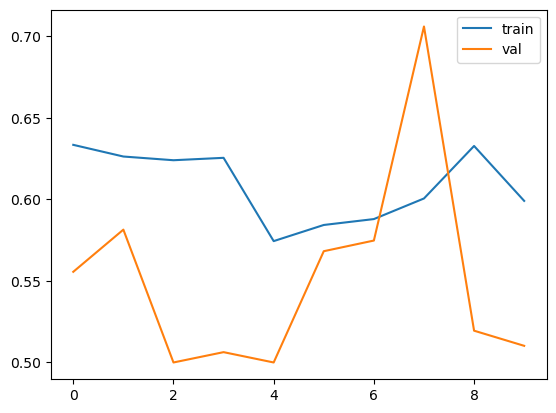

In [448]:
import xgboost

xgb_clf = xgboost.XGBClassifier(learning_rate=0.025, missing=np.nan, 
                                    seed=random_state, colsample_bytree=0.9, subsample=0.66)

param_grid = {"xgbclassifier__reg_alpha": np.logspace(-2,2,5),
              "xgbclassifier__reg_lambda": np.logspace(-2,2,5),
#               "xgbclassifier__max_depth": [1,10,100],
              "xgbclassifier__scale_pos_weight":[1,10,20]}

#NEED TO HAVE EVAL_SET TO DO LEARNING_RATE
xgb_train_scores, xgb_val_scores, xgb_best_models = MLpipe_StratKFold_fbeta2(X_small,y_small,preprocessor,
                                                                             xgb_clf,param_grid)
# MLpipe__fbeta2(X_other,y_other,preprocessor,param_grid)

print('mean max f-beta 2 train:',np.mean(xgb_train_scores))
print('std max f-beta 2 train:',np.std(xgb_train_scores))
print(xgb_train_scores)
print('mean max f-beta 2 val:',np.mean(xgb_val_scores))
print('std max f-beta 2 val:',np.std(xgb_val_scores))
print(xgb_val_scores)

plt.plot(range(10),xgb_train_scores,label='train')
plt.plot(range(10),xgb_val_scores,label='val')
plt.legend()
plt.show()

In [474]:
# def MLpipe_XGB_fbeta2(X, y, xgb_preprocessor, param_grid):

#     train_scores = []
#     val_scores = []
#     best_models = []

#     # your code here...
#     for random_state in range(10):
#         X_other,X_eval,y_other,y_eval = train_test_split(X,y,train_size=0.8,stratify=y,random_state=random_state)
#         X_train,X_val,y_train,y_val = train_test_split(X_other,y_other,train_size=0.8,stratify=y_other,random_state=random_state)
        
#         clf = xgboost.XGBClassifier(learning_rate=0.03, missing=np.nan, 
#                                     seed=random_state, colsample_bytree=0.9, subsample=0.66,
#                                     n_estimators=1000000,early_stopping_rounds=100,scoring=f2_scorer)
        
#         skf=StratifiedKFold(n_splits=4,shuffle=True,random_state=random_state)

#         pipe = make_pipeline(preprocessor,StandardScaler(),clf)

#         # pipe = make_pipeline(xgb_preprocessor,clf)

#         # X_train_prep = xgb_preprocessor.fit_transform(X_train)
#         # X_val_prep = xgb_preprocessor.transform(X_val)
#         # X_eval_prep = xgb_preprocessor.transform(X_eval)

#         # X_train_prep = preprocessor.fit_transform(X_train)
#         # # X_val_prep = preprocessor.transform(X_val)
#         # X_eval_prep = preprocessor.transform(X_eval)

#         # final_scaler = StandardScaler()
#         # X_train_prep = final_scaler.fit_transform(X_train)
#         # # X_val_prep = final_scaler.transform(X_val)
#         # X_eval_prep = final_scaler.transform(X_eval)


#         # 'estimator__columntransformer', 'estimator__standardscaler'
#         grid = GridSearchCV(pipe,param_grid=param_grid,
#                             cv=skf,return_train_score=True,n_jobs=7,verbose=2)
        
#         # X_eval_col = grid.get_params()['estimator__columntransformer'].transform(X_eval)
#         # X_eval_prep = grid.get_params()['estimator__standardscaler'].transform(X_eval_col)
        
#         # print(grid.get_params().keys())
#         # grid.fit(X_train,y_train)
#         fit_params = {'xgbclassifier__eval_set':[(preprocessor.transform(X_eval),y_eval)]}
#         # xgbclassifier__eval_set=[(preprocessor.transform(X_eval),y_eval)]
#         print('X_train',X_train.head())
#         print('X_eval',X_eval.head())
#         grid.fit(X_train,y_train,**fit_params)
#         y_train_pred = grid.predict(X_train)
#         y_val_pred = grid.predict(X_val)
        
#         train_scores.append(fbeta_score(y_train,y_train_pred,beta=2))
#         val_scores.append(fbeta_score(y_val,y_val_pred,beta=2))
#         best_models.append(grid)

#     return train_scores, val_scores, best_models

Fitting 4 folds for each of 54 candidates, totalling 216 fits


129061.71s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
129061.75s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
129061.78s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
129061.78s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
129061.79s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
129061.80s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
129061.91s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
0.01s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
0.01s - Debugge

[CV] END xgbclassifier__max_depth=1, xgbclassifier__reg_alpha=0.1, xgbclassifier__reg_lambda=0.1, xgbclassifier__scale_pos_weight=10; total time=   9.6s
[CV] END xgbclassifier__max_depth=1, xgbclassifier__reg_alpha=0.1, xgbclassifier__reg_lambda=0.1, xgbclassifier__scale_pos_weight=10; total time=   9.9s
[CV] END xgbclassifier__max_depth=1, xgbclassifier__reg_alpha=0.1, xgbclassifier__reg_lambda=0.1, xgbclassifier__scale_pos_weight=1; total time=  10.0s
[CV] END xgbclassifier__max_depth=1, xgbclassifier__reg_alpha=0.1, xgbclassifier__reg_lambda=0.1, xgbclassifier__scale_pos_weight=1; total time=  10.0s
[CV] END xgbclassifier__max_depth=1, xgbclassifier__reg_alpha=0.1, xgbclassifier__reg_lambda=0.1, xgbclassifier__scale_pos_weight=1; total time=  10.1s
[CV] END xgbclassifier__max_depth=1, xgbclassifier__reg_alpha=0.1, xgbclassifier__reg_lambda=0.1, xgbclassifier__scale_pos_weight=1; total time=  10.1s
[CV] END xgbclassifier__max_depth=1, xgbclassifier__reg_alpha=0.1, xgbclassifier__reg_

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
130219.25s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
0.01s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.


[CV] END xgbclassifier__max_depth=100, xgbclassifier__reg_alpha=0.1, xgbclassifier__reg_lambda=1.0, xgbclassifier__scale_pos_weight=1; total time= 2.2min
[CV] END xgbclassifier__max_depth=100, xgbclassifier__reg_alpha=0.1, xgbclassifier__reg_lambda=10.0, xgbclassifier__scale_pos_weight=1; total time= 1.7min
[CV] END xgbclassifier__max_depth=100, xgbclassifier__reg_alpha=0.1, xgbclassifier__reg_lambda=1.0, xgbclassifier__scale_pos_weight=10; total time= 3.0min
[CV] END xgbclassifier__max_depth=100, xgbclassifier__reg_alpha=0.1, xgbclassifier__reg_lambda=1.0, xgbclassifier__scale_pos_weight=10; total time= 3.0min
[CV] END xgbclassifier__max_depth=100, xgbclassifier__reg_alpha=0.1, xgbclassifier__reg_lambda=10.0, xgbclassifier__scale_pos_weight=1; total time= 1.7min
[CV] END xgbclassifier__max_depth=100, xgbclassifier__reg_alpha=0.1, xgbclassifier__reg_lambda=10.0, xgbclassifier__scale_pos_weight=1; total time= 1.7min
[CV] END xgbclassifier__max_depth=100, xgbclassifier__reg_alpha=0.1, xg

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
132612.35s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
0.01s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.


[CV] END xgbclassifier__max_depth=100, xgbclassifier__reg_alpha=0.1, xgbclassifier__reg_lambda=1.0, xgbclassifier__scale_pos_weight=10; total time= 3.0min
[CV] END xgbclassifier__max_depth=100, xgbclassifier__reg_alpha=0.1, xgbclassifier__reg_lambda=10.0, xgbclassifier__scale_pos_weight=1; total time= 1.7min
[CV] END xgbclassifier__max_depth=100, xgbclassifier__reg_alpha=0.1, xgbclassifier__reg_lambda=10.0, xgbclassifier__scale_pos_weight=10; total time= 2.5min
[CV] END xgbclassifier__max_depth=100, xgbclassifier__reg_alpha=0.1, xgbclassifier__reg_lambda=10.0, xgbclassifier__scale_pos_weight=10; total time= 2.5min
[CV] END xgbclassifier__max_depth=100, xgbclassifier__reg_alpha=0.1, xgbclassifier__reg_lambda=10.0, xgbclassifier__scale_pos_weight=10; total time= 2.6min
[CV] END xgbclassifier__max_depth=100, xgbclassifier__reg_alpha=1.0, xgbclassifier__reg_lambda=0.1, xgbclassifier__scale_pos_weight=1; total time= 2.0min
[CV] END xgbclassifier__max_depth=100, xgbclassifier__reg_alpha=1.0,

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
134600.46s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
0.01s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.


[CV] END xgbclassifier__max_depth=100, xgbclassifier__reg_alpha=0.1, xgbclassifier__reg_lambda=0.1, xgbclassifier__scale_pos_weight=10; total time= 3.0min
[CV] END xgbclassifier__max_depth=100, xgbclassifier__reg_alpha=0.1, xgbclassifier__reg_lambda=0.1, xgbclassifier__scale_pos_weight=10; total time= 3.0min


134615.62s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
0.01s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
134616.53s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
0.01s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.


[CV] END xgbclassifier__max_depth=100, xgbclassifier__reg_alpha=0.1, xgbclassifier__reg_lambda=1.0, xgbclassifier__scale_pos_weight=1; total time= 2.1min
[CV] END xgbclassifier__max_depth=100, xgbclassifier__reg_alpha=0.1, xgbclassifier__reg_lambda=1.0, xgbclassifier__scale_pos_weight=1; total time= 2.1min
[CV] END xgbclassifier__max_depth=100, xgbclassifier__reg_alpha=0.1, xgbclassifier__reg_lambda=1.0, xgbclassifier__scale_pos_weight=1; total time= 2.1min
[CV] END xgbclassifier__max_depth=100, xgbclassifier__reg_alpha=0.1, xgbclassifier__reg_lambda=0.1, xgbclassifier__scale_pos_weight=10; total time= 3.0min


134711.35s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
0.01s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.


[CV] END xgbclassifier__max_depth=100, xgbclassifier__reg_alpha=0.1, xgbclassifier__reg_lambda=1.0, xgbclassifier__scale_pos_weight=1; total time= 2.1min
[CV] END xgbclassifier__max_depth=100, xgbclassifier__reg_alpha=0.1, xgbclassifier__reg_lambda=10.0, xgbclassifier__scale_pos_weight=1; total time= 1.6min
[CV] END xgbclassifier__max_depth=100, xgbclassifier__reg_alpha=0.1, xgbclassifier__reg_lambda=1.0, xgbclassifier__scale_pos_weight=10; total time= 2.8min
[CV] END xgbclassifier__max_depth=100, xgbclassifier__reg_alpha=0.1, xgbclassifier__reg_lambda=1.0, xgbclassifier__scale_pos_weight=10; total time= 2.8min
[CV] END xgbclassifier__max_depth=100, xgbclassifier__reg_alpha=0.1, xgbclassifier__reg_lambda=10.0, xgbclassifier__scale_pos_weight=1; total time= 1.6min
[CV] END xgbclassifier__max_depth=100, xgbclassifier__reg_alpha=0.1, xgbclassifier__reg_lambda=10.0, xgbclassifier__scale_pos_weight=1; total time= 1.6min
[CV] END xgbclassifier__max_depth=100, xgbclassifier__reg_alpha=0.1, xg

134841.36s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
0.01s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.


[CV] END xgbclassifier__max_depth=100, xgbclassifier__reg_alpha=0.1, xgbclassifier__reg_lambda=1.0, xgbclassifier__scale_pos_weight=10; total time= 2.8min
[CV] END xgbclassifier__max_depth=100, xgbclassifier__reg_alpha=0.1, xgbclassifier__reg_lambda=10.0, xgbclassifier__scale_pos_weight=1; total time= 1.6min
[CV] END xgbclassifier__max_depth=100, xgbclassifier__reg_alpha=0.1, xgbclassifier__reg_lambda=10.0, xgbclassifier__scale_pos_weight=10; total time= 2.5min
[CV] END xgbclassifier__max_depth=100, xgbclassifier__reg_alpha=0.1, xgbclassifier__reg_lambda=10.0, xgbclassifier__scale_pos_weight=10; total time= 2.5min
[CV] END xgbclassifier__max_depth=100, xgbclassifier__reg_alpha=1.0, xgbclassifier__reg_lambda=0.1, xgbclassifier__scale_pos_weight=1; total time= 2.0min
[CV] END xgbclassifier__max_depth=100, xgbclassifier__reg_alpha=0.1, xgbclassifier__reg_lambda=10.0, xgbclassifier__scale_pos_weight=10; total time= 2.5min
[CV] END xgbclassifier__max_depth=100, xgbclassifier__reg_alpha=1.0,

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
136720.29s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
0.01s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.


[CV] END xgbclassifier__max_depth=100, xgbclassifier__reg_alpha=0.1, xgbclassifier__reg_lambda=0.1, xgbclassifier__scale_pos_weight=10; total time= 2.9min
[CV] END xgbclassifier__max_depth=100, xgbclassifier__reg_alpha=0.1, xgbclassifier__reg_lambda=0.1, xgbclassifier__scale_pos_weight=10; total time= 2.9min


136732.30s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
0.01s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.


[CV] END xgbclassifier__max_depth=100, xgbclassifier__reg_alpha=0.1, xgbclassifier__reg_lambda=1.0, xgbclassifier__scale_pos_weight=1; total time= 2.1min
[CV] END xgbclassifier__max_depth=100, xgbclassifier__reg_alpha=0.1, xgbclassifier__reg_lambda=1.0, xgbclassifier__scale_pos_weight=1; total time= 2.1min
[CV] END xgbclassifier__max_depth=100, xgbclassifier__reg_alpha=0.1, xgbclassifier__reg_lambda=1.0, xgbclassifier__scale_pos_weight=1; total time= 2.1min
[CV] END xgbclassifier__max_depth=100, xgbclassifier__reg_alpha=0.1, xgbclassifier__reg_lambda=0.1, xgbclassifier__scale_pos_weight=10; total time= 2.9min
[CV] END xgbclassifier__max_depth=100, xgbclassifier__reg_alpha=0.1, xgbclassifier__reg_lambda=1.0, xgbclassifier__scale_pos_weight=1; total time= 2.1min
[CV] END xgbclassifier__max_depth=100, xgbclassifier__reg_alpha=0.1, xgbclassifier__reg_lambda=10.0, xgbclassifier__scale_pos_weight=1; total time= 1.6min
[CV] END xgbclassifier__max_depth=100, xgbclassifier__reg_alpha=0.1, xgbcl

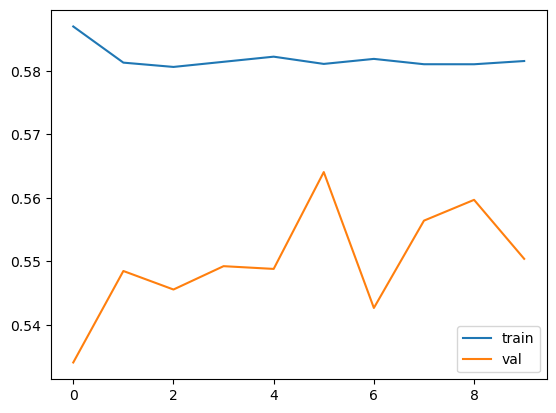

In [484]:
##DO XGBOOST WITHOUT STANDARDSCALER!!
##TRY RANDOMFOREST CLASSIFIER WITHOUT STANDARDSCALER!!

xgb_clf = xgboost.XGBClassifier(learning_rate=0.03,missing=np.nan, 
                                seed=random_state, colsample_bytree=0.9, subsample=0.66)

param_grid = {"xgbclassifier__reg_alpha": np.logspace(-1,1,3),
              "xgbclassifier__reg_lambda": np.logspace(-1,1,3),
              "xgbclassifier__max_depth": [1,10,100],
              "xgbclassifier__scale_pos_weight":[1,10]}

xgb_preprocessor = ColumnTransformer(
    transformers=[
        ('ord', OrdinalEncoder(categories = ordinal_cats), ordinal_ftrs),
        ('onehot', OneHotEncoder(handle_unknown='ignore'), onehot_ftrs),
        ('std', StandardScaler(), std_ftrs)])

#NEED TO HAVE EVAL_SET TO DO LEARNING_RATE
xgb_train_scores, xgb_val_scores, xgb_best_models = MLpipe_StratKFold_fbeta2(X_other,y_other,
                                                                             preprocessor,xgb_clf,
                                                                             param_grid)
# MLpipe__fbeta2(X_other,y_other,preprocessor,param_grid)

print('mean max f-beta 2 train:',np.mean(xgb_train_scores))
print('std max f-beta 2 train:',np.std(xgb_train_scores))
print(xgb_train_scores)
print('mean max f-beta 2 val:',np.mean(xgb_val_scores))
print('std max f-beta 2 val:',np.std(xgb_val_scores))
print(xgb_val_scores)

plt.plot(range(10),xgb_train_scores,label='train')
plt.plot(range(10),xgb_val_scores,label='val')
plt.legend()
plt.show()

In [485]:
# import pickle
# file = open('results/xgb_depth_grid.save', 'wb')
# pickle.dump((xgb_train_scores, xgb_val_scores, xgb_best_models),file)
# file.close()

In [ ]:
import pickle
file = open('results/xgb_edited_grid.save', 'wb')
pickle.dump((xgb_edited_train_scores, xgb_edited_val_scores, xgb_edited_best_models,
             xgb_best_preprocessors, xgb_best_final_scalers),file)
file.close()

In [154]:
# import pickle
# file = open('results/xgb_grid.save', 'wb')
# pickle.dump((xgb_train_scores, xgb_val_scores, xgb_best_models),file)
# file.close()

In [155]:
from sklearn.neighbors import KNeighborsClassifier

knc_clf = KNeighborsClassifier()
param_grid = {'kneighborsclassifier__n_neighbors':[1,10,100,1000],
              'kneighborsclassifier__weights':[None,'uniform','distance']}

knc_train_scores, knc_val_scores, knc_best_models = MLpipe_StratKFold_fbeta2(X_small,y_small,preprocessor,
                                                                              knc_clf,param_grid)

print('mean max f-beta 2 train:',np.mean(knc_train_scores))
print('std max f-beta 2 train:',np.std(knc_train_scores))
print(knc_train_scores)
print('mean max f-beta 2 val:',np.mean(knc_val_scores))
print('std max f-beta 2 val:',np.std(knc_val_scores))
print(knc_val_scores)

plt.plot(range(10),knc_train_scores,label='train')
plt.plot(range(10),knc_val_scores,label='val')
plt.legend()
plt.show()

Fitting 4 folds for each of 12 candidates, totalling 48 fits
[CV] END kneighborsclassifier__n_neighbors=1, kneighborsclassifier__weights=uniform; total time=   0.1s
[CV] END kneighborsclassifier__n_neighbors=1, kneighborsclassifier__weights=uniform; total time=   0.1s
[CV] END kneighborsclassifier__n_neighbors=1, kneighborsclassifier__weights=uniform; total time=   0.1s
[CV] END kneighborsclassifier__n_neighbors=1, kneighborsclassifier__weights=None; total time=   0.1s
[CV] END kneighborsclassifier__n_neighbors=1, kneighborsclassifier__weights=uniform; total time=   0.0s
[CV] END kneighborsclassifier__n_neighbors=1, kneighborsclassifier__weights=None; total time=   0.1s
[CV] END kneighborsclassifier__n_neighbors=1, kneighborsclassifier__weights=None; total time=   0.1s
[CV] END kneighborsclassifier__n_neighbors=1, kneighborsclassifier__weights=distance; total time=   0.0s
[CV] END kneighborsclassifier__n_neighbors=1, kneighborsclassifier__weights=None; total time=   0.1s
[CV] END kneig

KeyboardInterrupt: 

In [ ]:
import pickle
file = open('results/knc_grid.save', 'wb')
pickle.dump((knc_train_scores, knc_val_scores, knc_best_models),file)
file.close()

NameError: name 'knc_train_scores' is not defined

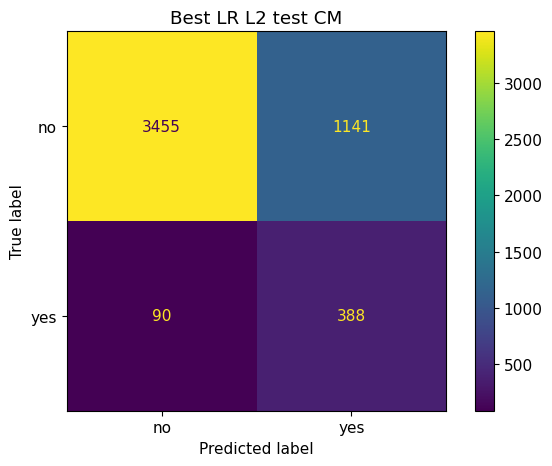

0.5637895960476607


In [ ]:
best_test_model = lr_best_models[np.argmax(lr_test_scores)]

test_cf = confusion_matrix(y_test,best_test_model.predict(X_test))
disp = ConfusionMatrixDisplay(test_cf,display_labels=['no', 'yes'])
fig, ax = plt.subplots()
disp.plot(ax=ax)
plt.title('Best LR L2 test CM')
plt.tight_layout()
plt.savefig('lr l2 cm',dpi=300,bbox_inches='tight')
plt.show()

print(lr_test_scores[np.argmax(lr_test_scores)])

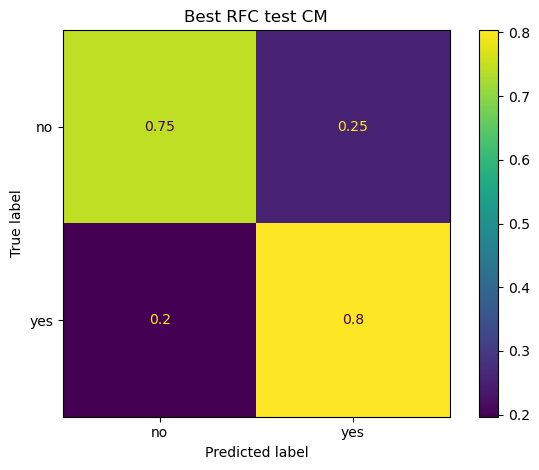

0.5545927209705372


In [ ]:
best_test_model = rfc_best_models[np.argmax(rfc_test_scores)]

test_cf = confusion_matrix(y_test,best_test_model.predict(X_test),normalize='true')
disp = ConfusionMatrixDisplay(test_cf,display_labels=['no', 'yes'])
fig, ax = plt.subplots()
disp.plot(ax=ax)
plt.title('Best RFC test CM')
plt.tight_layout()
plt.savefig('rfc cm',dpi=300,bbox_inches='tight')
plt.show()

print(rfc_test_scores[np.argmax(rfc_test_scores)])

In [ ]:
print(lr_best_models[0].best_params_)

{'logisticregression__C': 0.01, 'logisticregression__class_weight': 'balanced'}


In [ ]:
from sklearn.inspection import permutation_importance

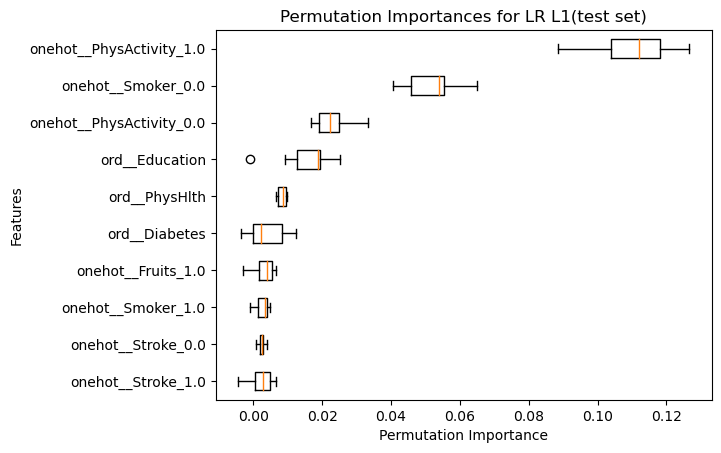

In [ ]:
models = lr_best_models
test_scores = lr_test_scores
perm_imp = permutation_importance(models[np.argmax(test_scores)],X_test,y_test,scoring=f2_scorer,
                       random_state=random_state,n_repeats=10)
importances = perm_imp.importances_mean
importances_raw = perm_imp.importances

sorted_indices = np.argsort(importances)[-10:] 
col_names = models[np.argmax(test_scores)].best_estimator_[:-1].get_feature_names_out()

plt.boxplot(importances_raw[sorted_indices].T,labels=col_names[sorted_indices],vert=False)
plt.title("Permutation Importances for LR L1(test set)")
plt.xlabel('Permutation Importance')
plt.ylabel('Features')
plt.savefig('perm imp lr l1.png',dpi=300,bbox_inches='tight')
plt.show()

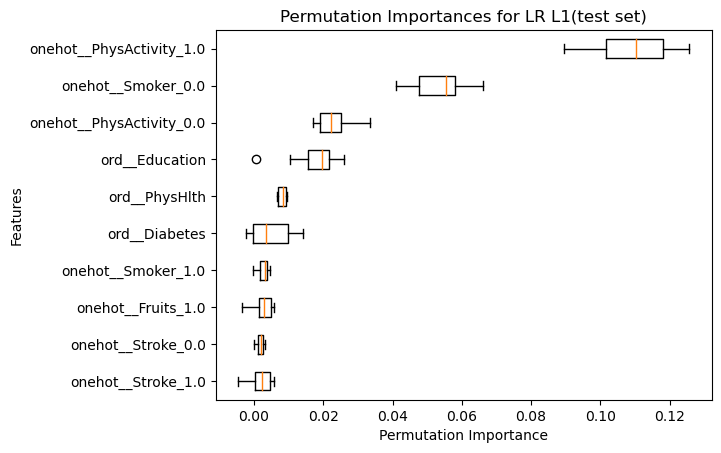

In [ ]:
models = lr_l1_best_models
test_scores = lr_l1_test_scores
perm_imp = permutation_importance(models[np.argmax(test_scores)],X_test,y_test,scoring=f2_scorer,
                       random_state=random_state,n_repeats=10)
importances = perm_imp.importances_mean
importances_raw = perm_imp.importances

sorted_indices = np.argsort(importances)[-10:] 
col_names2 = models[np.argmax(test_scores)].best_estimator_[:-1].get_feature_names_out()

plt.boxplot(importances_raw[sorted_indices].T,labels=col_names2[sorted_indices],vert=False)
plt.title("Permutation Importances for LR L1(test set)")
plt.xlabel('Permutation Importance')
plt.ylabel('Features')
plt.savefig('perm imp lr l1.png',dpi=300,bbox_inches='tight')
plt.show()

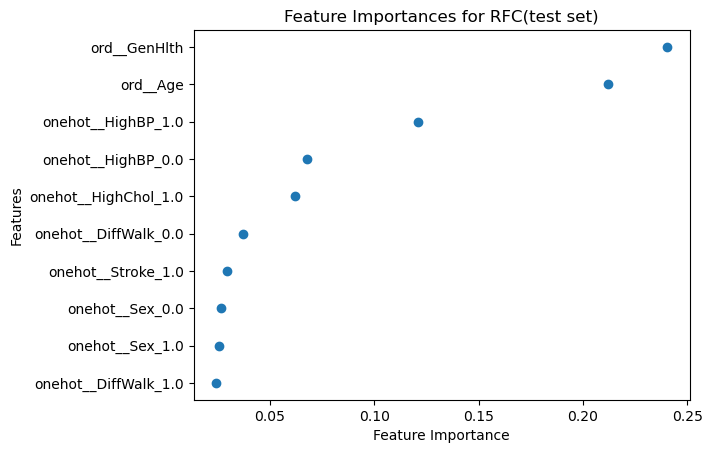

In [ ]:
models = rfc_best_models
test_scores = rfc_test_scores

importances = models[np.argmax(rfc_test_scores)].best_estimator_[-1].feature_importances_

sorted_indices = np.argsort(importances)[-10:] 
col_names = models[np.argmax(rfc_test_scores)].best_estimator_[:-1].get_feature_names_out()

plt.scatter(importances[sorted_indices],range(10))
plt.title("Feature Importances for RFC(test set)")
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.yticks(range(10),col_names[sorted_indices])
plt.savefig('feature imp RFC.png',dpi=300,bbox_inches='tight')
plt.show()

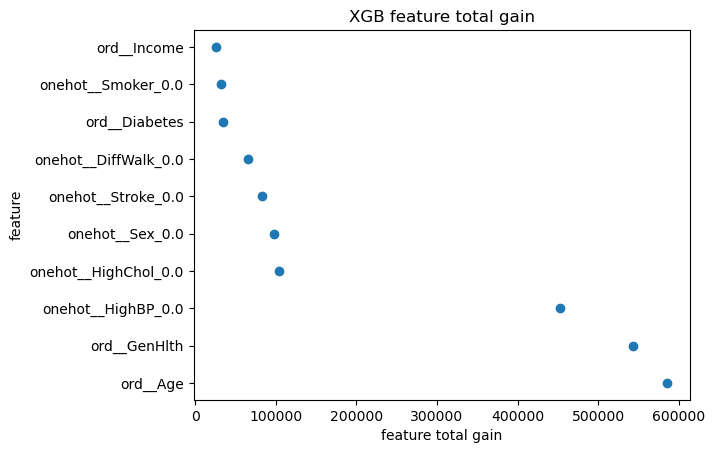

In [ ]:
models = xgb_best_models
test_scores = xgb_test_scores

gains = models[np.argmax(rfc_test_scores)].best_estimator_[-1].get_booster()\
                .get_score(importance_type='total_gain')

sorted_gains = sorted(gains.items(),key=lambda item:item[1])[-1:-11:-1]
x,y = zip(*sorted_gains)
plt.scatter(y,x)
plt.xlabel('feature total gain')
plt.ylabel('feature')
plt.title('XGB feature total gain')
plt.yticks(['f2','f13','f0','f29','f15','f31','f9','f7','f3','f6'],
            col_names[[2,13,0,29,15,31,9,7,3,6]])
plt.savefig('total gain XGB.png',dpi=300,bbox_inches='tight')
plt.show()

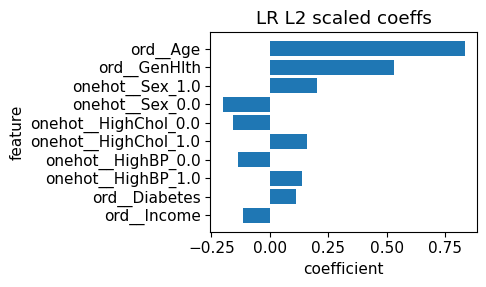

In [ ]:
coefs = lr_best_models[np.argmax(lr_test_scores)].best_estimator_[-1].coef_[0]
sorted_indcs = np.argsort(np.abs(coefs))

col_names = models[np.argmax(test_scores)].best_estimator_[:-1].get_feature_names_out()

plt.figure(figsize=(5,3))
plt.rcParams.update({'font.size': 11})
plt.barh(np.arange(10),coefs[sorted_indcs[-10:]])
plt.yticks(np.arange(10),col_names[sorted_indcs[-10:]])
plt.xlabel('coefficient')
plt.ylabel('feature')
plt.title('LR L2 scaled coeffs')
plt.tight_layout()
plt.savefig('LR l2 scaled coefs.png',dpi=300)
plt.show()